In [21]:
import sklearn
import pandas as pd
import numpy as np
from numpy import std, mean
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#Read data from text file
with open('data.txt', 'r') as file:
    lines = file.readlines()
diabetes = pd.DataFrame()

# Process data row by row and add to DataFrame
for line in lines:
    parts = line.strip().split()
    label = int(parts[0]) 
    features = {}
    for part in parts[1:]:
        feature_number, feature_value = part.split(':')
        features[int(feature_number)] = float(feature_value)
        
    row_data = {'Label': label, **features}
    diabetes = diabetes.append(row_data, ignore_index=True)

In [22]:
diabetes = diabetes.dropna(subset=[1]) 
diabetes = diabetes.dropna(subset=[2]) 
diabetes = diabetes.dropna(subset=[3])
diabetes = diabetes.dropna(subset=[4]) 
diabetes = diabetes.dropna(subset=[5]) 
diabetes = diabetes.dropna(subset=[6]) 
diabetes = diabetes.dropna(subset=[7]) 
diabetes = diabetes.dropna(subset=[8]) 

In [24]:
# Divide features and labels
X = diabetes[[1,2,3,4,5,6,7,8]]
X=X.values
y = diabetes['Label'] 
y= y.values
# Divide training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred=[ ]

In [25]:
class Perceptron:
    def __init__(self, input_size, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = np.zeros(input_size + 1)  # Additional weight for the bias
        self.history = []

    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return 1 if summation > 0 else -1

    def train(self, training_data, labels):
        for _ in range(self.epochs):
            errors = 0
            for inputs, label in zip(training_data, labels):
                prediction = self.predict(inputs)
                update = self.learning_rate * (label - prediction)
                self.weights[1:] += update * inputs
                self.weights[0] += update
                errors += int(update != 0)
            self.history.append(errors)

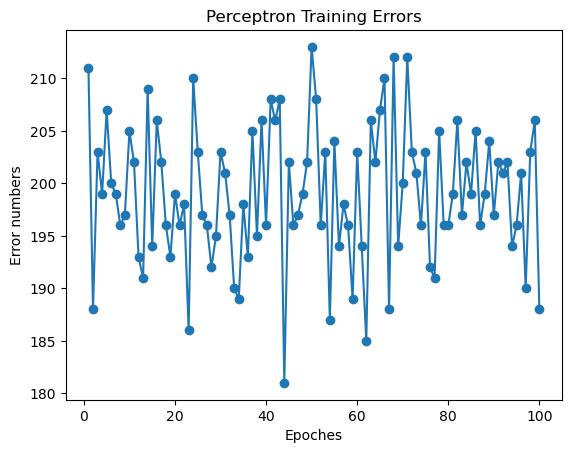

              precision    recall  f1-score   support

    diabetes       0.88      0.15      0.25        47
non-diabetes       0.72      0.99      0.84       105

    accuracy                           0.73       152
   macro avg       0.80      0.57      0.54       152
weighted avg       0.77      0.73      0.66       152



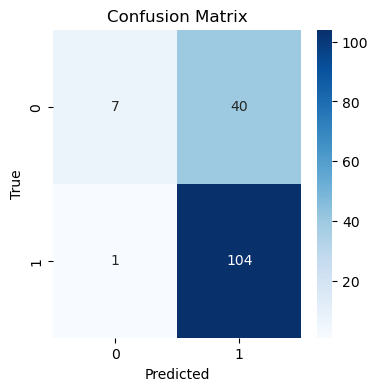

In [28]:
if __name__ == '__main__':
    perceptron = Perceptron(input_size=8, learning_rate=0.1,epochs=100)
    perceptron.train(X_train,y_train)
    for inputs in X_test:
        prediction = perceptron.predict(inputs)
        y_pred.append(prediction)
        
# Visualize the number of errors in each epoch (visualize convergence         
    plt.plot(range(1, len(perceptron.history) + 1), perceptron.history, marker = 'o')
    plt.xlabel('Epoches')
    plt.ylabel('Error numbers')
    plt.title('Perceptron Training Errors')
    plt.show()
    print(classification_report(y_test, y_pred, target_names=['diabetes', 'non-diabetes' ]))


 # Calculate and visualize confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [29]:
# Build MLP using keras
def create_model(hidden_units=32, learning_rate=0.01, activation='relu'):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=8, activation=activation))
    model.add(Dense(hidden_units,  activation=activation))
    model.add(Dense(hidden_units,  activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Define parameter grid and perform a grid search
param_grid = {
    'hidden_units': [32, 128, 256],
    'learning_rate': [0.01, 0.1, 0.001],
    'activation': ['relu', 'tanh', 'sigmoid']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)
print("Best parameters found: ", grid_result.best_params_)
print("Best accuracy found: ", grid_result.best_score_)

# Evaluate model performance
best_model = grid_result.best_estimator_
y_pred=best_model.predict(X_test)
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy of the best model: ", test_accuracy)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'activation': 'relu', 'hidden_units': 128, 'learning_rate': 0.01}
Best accuracy found:  0.7578240633010864
5/5 [==============================] - 0s 1ms/step
Test accuracy of the best model:  0.8092105388641357


In [30]:
print(classification_report(y_test, y_pred, target_names=['diabetes', 'non-diabetes' ]))

              precision    recall  f1-score   support

    diabetes       0.74      0.60      0.66        47
non-diabetes       0.83      0.90      0.87       105

    accuracy                           0.81       152
   macro avg       0.79      0.75      0.76       152
weighted avg       0.80      0.81      0.80       152



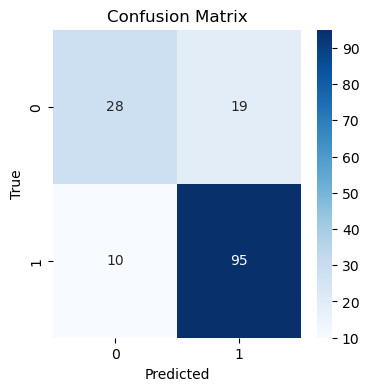

In [31]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [20]:
class MultilayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, epochs=100):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # Initialize weights and biases
        self.weights_input_hidden = np.random.rand(self.input_size, self.hidden_size)
        self.bias_hidden = np.zeros(self.hidden_size)
        self.weights_hidden_output = np.random.rand(self.hidden_size, self.output_size)
        self.bias_output = np.zeros(self.output_size)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward(self, inputs):
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.output_layer_output = self.sigmoid(self.output_layer_input)
        
        return 1 if self.output_layer_output > 0.5 else -1
    
    def train(self, training_data, labels):
        for epoch in range(self.epochs):
            for inputs, label in zip(training_data, labels):
                ## forward propagation
                self.forward(inputs)                
                ## Back propagation
                error = label - self.output_layer_output
                output_delta = error * self.sigmoid_derivative(self.output_layer_output)                
                hidden_layer_error = output_delta.dot(self.weights_hidden_output.T)
                hidden_layer_delta = hidden_layer_error * self.sigmoid_derivative(self.hidden_layer_output)                
                # Update weights and biases
                self.weights_hidden_output += self.hidden_layer_output.reshape(-1, 1) * output_delta * self.learning_rate
                self.bias_output += output_delta * self.learning_rate
                self.weights_input_hidden += inputs.reshape(-1, 1) * hidden_layer_delta * self.learning_rate
                self.bias_hidden += hidden_layer_delta * self.learning_rate

if __name__ == "__main__":
    #Define MLP parameters
    input_size = 8
    hidden_size = 32
    output_size = 1
    mlp = MultilayerPerceptron(input_size, hidden_size, output_size)
    mlp.train(X_train,y_train)

    # Test MLP
    y_pred=[ ]
    for inputs in X_test:
        prediction =  mlp.forward(inputs)
        y_pred.append(prediction)
    #Compute model performance
    print(classification_report(y_test, y_pred, target_names=['diabetes', 'non-diabetes' ]))

              precision    recall  f1-score   support

    diabetes       0.49      0.91      0.64        47
non-diabetes       0.94      0.58      0.72       105

    accuracy                           0.68       152
   macro avg       0.72      0.75      0.68       152
weighted avg       0.80      0.68      0.69       152

